In [4]:
! pip install tabulate

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [39]:
from OurTrainingTools import *

def test_model(madminermodel, test_input_sm, test_input_bsm, epochs, e, n_meas, pm, verbose_t=True, verbose_period_t=1e5, title=''):
        
        def compute_t(madminermodel, nev, counter, test_input):
            n_gen = 0
            while n_gen == 0:
                n_gen = np.random.poisson(nev)
            
            if (counter + n_gen) >= len(test_input):
                return 0., -1
            
            points = test_input[int(counter): int(counter+n_gen)]
            #print('counter = %d, counter+n_gen = %d'%(counter, counter+n_gen))
            #ratio = (madminermodel.evaluate_log_likelihood_ratio(points.cpu().numpy(), 
            #                                np.array([0.]))[0][0])
            log_ratio = (madminermodel.evaluate_log_likelihood_ratio(points.numpy(), 
                                            np.array([0.]))[0][0])
            log_ratio = torch.tensor(log_ratio)
            #ratio = 1./ratio
            log_ratio = log_ratio
            out  = 2 * (NBSM - NSM - (log_ratio+torch.log(torch.tensor(NBSM/NSM))).sum(0))
            return out, int(counter+n_gen)
        
        test_start = time.time()
        if verbose_t:
            print("NSM = %.3f --- NBSM = %.3f"%(NSM, NBSM))
        tsm  = torch.empty(n_meas)
        tbsm = torch.empty(n_meas)
        
        tsmcount  = torch.zeros(n_meas+1)
        tbsmcount = torch.zeros(n_meas+1)
            
        for i in range(n_meas):
            tsm[i], tsmcount[i+1] = compute_t(madminermodel, NSM, tsmcount[i], 
                                       test_input_sm)
            tbsm[i], tbsmcount[i+1] = compute_t(madminermodel, NBSM, tbsmcount[i], 
                                       test_input_bsm)
            
            if (tsmcount[i+1] < 0) or (tbsmcount[i+1] < 0):
                print('Reaching the end of test data. Stop tests at %d. '%i)
                tsm, tbsm = tsm[: i], tbsm[: i]
                n_meas = i
                break
                
            if i % (verbose_period_t) == 0:
                print('test %s: tsm = %.3f,  tbsm = %.3f'%(
                        str(i).ljust(4), tsm[i], tbsm[i]))
        
        test_duration = time.time() - test_start
        
        mu_sm     = tsm.mean().item()
        mu_bsm    = tbsm.mean().item()
        sigma_sm  = tsm.std().item()
        sigma_bsm = tbsm.std().item()
        med_sm    = tsm.median().item()
        
        sep    = (mu_sm - mu_bsm)/sigma_bsm
        p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm) 
        #print(len([i for i in tbsm if i>med_sm]))
        delta1 = (p * (1 - p)/n_meas)**0.5
        delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
                2 * sigma_bsm**2))/(2*(n_meas**0.5))
        print('===> delta1 = %.3f, delta2 = %.3f'%(delta1, delta2))
        deltap = (delta1**2 + delta2**2)**0.5
        
        if verbose_t:
            print('p = %.3f +/- %.3f' %(p, deltap))
            print('Separation = %.2f sigmas'%(sep))
            training_properties = '/toydata/madminer-carl-'+title
            plot_histogram(tsm, tbsm, int(NSM), int(NBSM), p, deltap, sep, epochs, e, 
                                training_properties, results_path)
            print('Partial test after %d epochs (took %.2f seconds)\n'
                          %(e, test_duration))
            
        
        return tsm, tbsm, NSM, NBSM

In [6]:
def plot_histogram(tsm, tbsm, nsm, nbsm, p, deltap, sep, epochs, 
                   e, training_properties, results_folder):
    mint = torch.min(torch.cat((tsm, tbsm))).item()
    maxt = torch.max(torch.cat((tsm, tbsm))).item()
    
    # for some reason the code complains if i don't detach the variables 
    # from their grad-on versions
    tsm, tbsm = tsm.detach(), tbsm.detach()
    
    bins = np.linspace(mint, maxt, 60)
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    plt.hist(tsm,  bins, alpha=0.5, label='SM')
    plt.hist(tbsm, bins, alpha=0.5, label='BSM')
    plt.legend(loc='upper right')
    
    sn   = 'nsm = %s \nnbsm = %s'%(str(nsm), str(nbsm))
    sp   = 'p      '+'= '+ ('%.3f +/- %.3f'%(p, deltap))
    ssep = 'sep   ' + '= ' + ('%.3f'%(sep))
    
    plt.text(x=0.05, y=0.85, transform=ax.transAxes, 
         s=sn+'\n'+sp+'\n'+ssep, bbox=dict(facecolor='blue', alpha=0.2))
    plt.xlabel('t')
    plt.ylabel('p(t)')
    if epochs == e:
        plt.title('Final test\n' + training_properties)
        filename = results_folder + training_properties \
                    + ' histogram.pdf'
        plt.savefig(filename)
        return 
    plt.title(training_properties)
    plt.show()
    
    return

In [8]:
from madminer import ParameterizedRatioEstimator
from madminer.ml.morphing_aware import MorphingAwareRatioEstimator

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

# In Sample Test

In [10]:
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_50_in.h5', 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

In [11]:
Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 372.309,  tbsm = -467.241
Reaching the end of test data. Stop tests at 176. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 12.22 sigmas
Partial test after 1 epochs (took 35.50 seconds)



(tensor([372.3088, 536.2662, 427.9580, 395.0504, 382.5649, 323.1160, 467.0016,
         439.1082, 480.2043, 362.3309, 409.7758, 399.1116, 393.8975, 372.7985,
         456.2903, 561.3904, 382.0223, 520.1276, 438.5421, 411.9276, 526.2781,
         347.1064, 417.7982, 369.4116, 543.7470, 513.4364, 478.0151, 596.1177,
         464.7519, 485.3652, 630.7734, 396.8385, 473.9955, 489.5366, 636.2640,
         508.2391, 476.0079, 494.3373, 460.8384, 447.6069, 423.5204, 377.7553,
         309.0608, 487.5273, 570.1453, 490.5325, 531.3895, 473.8409, 538.1675,
         409.8674, 309.6638, 474.1954, 482.0854, 447.6241, 429.2579, 373.3405,
         376.9269, 497.1060, 502.5411, 437.8635, 507.7893, 567.9786, 514.7694,
         486.7926, 492.5654, 413.1345, 395.5750, 385.2564, 462.9806, 456.2524,
         285.1490, 414.1010, 345.4773, 357.2927, 480.8572, 485.3831, 508.8774,
         393.4388, 492.3460, 314.4871, 502.5135, 565.6207, 445.1946, 413.4507,
         462.6506, 378.0443, 467.9334, 445.4836, 360

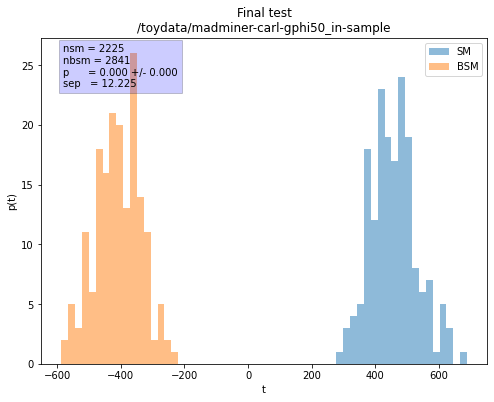

In [14]:
test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', verbose_t=True, verbose_period_t=1e5, title='gphi50_in-sample')

In [62]:
f.close()

NSM = 2225.504 --- NBSM = 6502.484
test 0   : tsm = 4019.440,  tbsm = -11030.900
Reaching the end of test data. Stop tests at 76. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 49.91 sigmas
Partial test after 1 epochs (took 23.96 seconds)



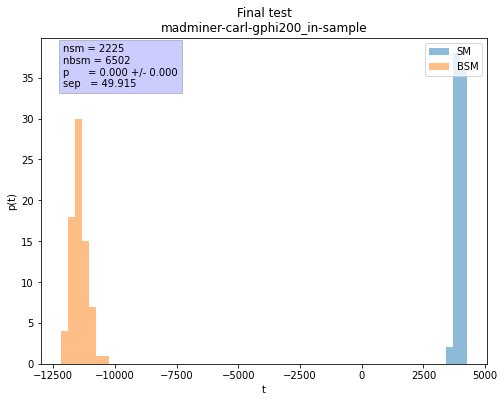

In [63]:
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_200_in.h5', 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi200_in-sample')
f.close()

NSM = 2225.504 --- NBSM = 21984.864
test 0   : tsm = 30013.719,  tbsm = -94763.453
Reaching the end of test data. Stop tests at 22. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 114.76 sigmas
Partial test after 1 epochs (took 18.93 seconds)



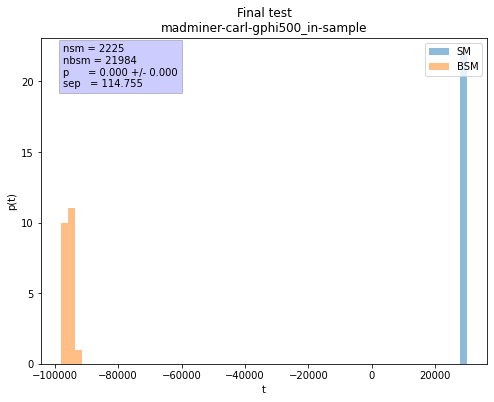

In [64]:
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_500_in.h5', 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi500_in-sample')
f.close()

# Out Sample Test Data
Old Format

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 296.204,  tbsm = -524.268
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 11.66 sigmas
Partial test after 1 epochs (took 40.61 seconds)



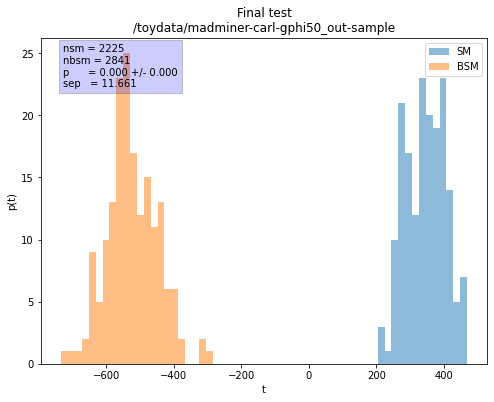

In [10]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2268.608
test 0   : tsm = 181.149,  tbsm = 126.704
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.032, delta2 = 0.029
p = 0.323 +/- 0.043
Separation = 0.42 sigmas
Partial test after 1 epochs (took 36.21 seconds)



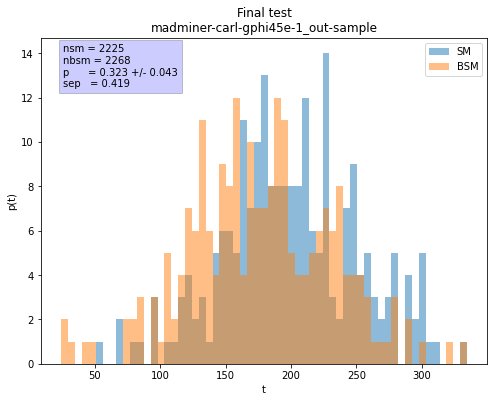

In [73]:
gphival = '45e-1'
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%s.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%s_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2268.608
test 0   : tsm = 220.502,  tbsm = 209.234
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.032, delta2 = 0.030
p = 0.332 +/- 0.043
Separation = 0.41 sigmas
Partial test after 1 epochs (took 40.48 seconds)



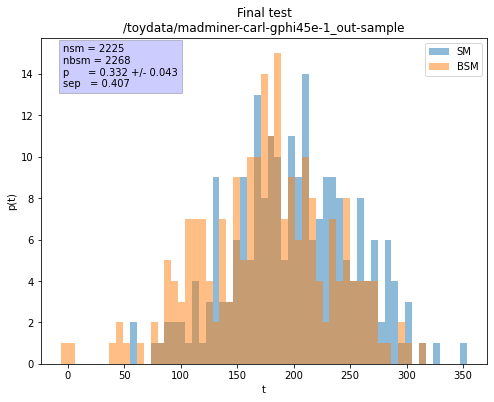

In [25]:
gphival = '45e-1'
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%s.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%s_out-sample'%(gphival))

f.close()

### Models traied on 24.Sep.2020

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 210.031,  tbsm = -600.851
Reaching the end of test data. Stop tests at 176. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 13.85 sigmas
Partial test after 1 epochs (took 38.77 seconds)



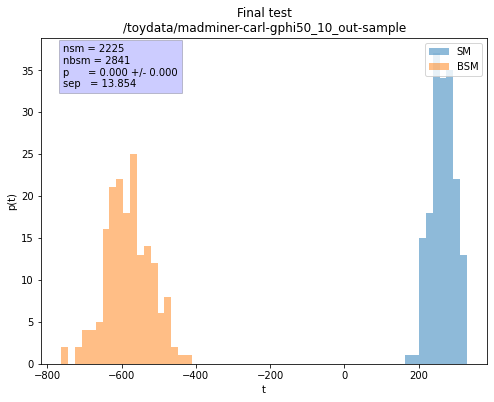

In [18]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl10')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_10_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 288.174,  tbsm = -621.788
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 13.36 sigmas
Partial test after 1 epochs (took 37.83 seconds)



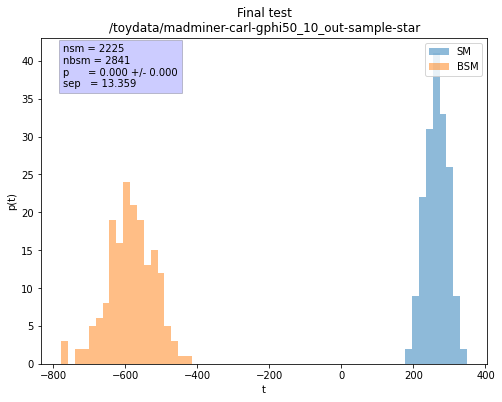

In [24]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl10')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_10_out-sample-star'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 350.299,  tbsm = -586.113
Reaching the end of test data. Stop tests at 176. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 13.04 sigmas
Partial test after 1 epochs (took 41.87 seconds)



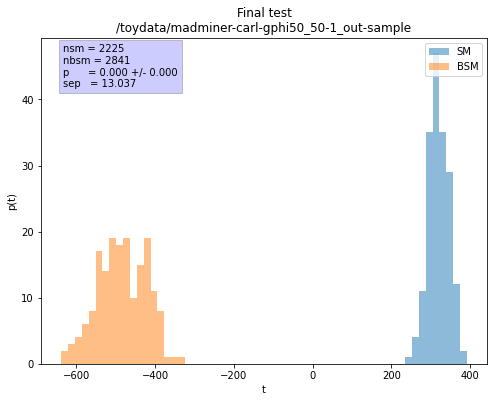

In [12]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl50-1')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_50-1_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 463.541,  tbsm = -325.429
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 12.40 sigmas
Partial test after 1 epochs (took 40.79 seconds)



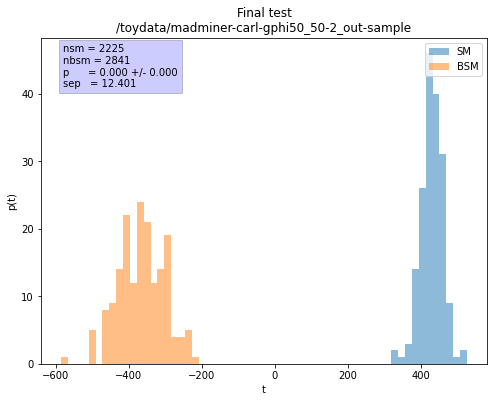

In [13]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl50-2')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_50-2_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 245.246,  tbsm = -481.885
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 12.45 sigmas
Partial test after 1 epochs (took 37.49 seconds)



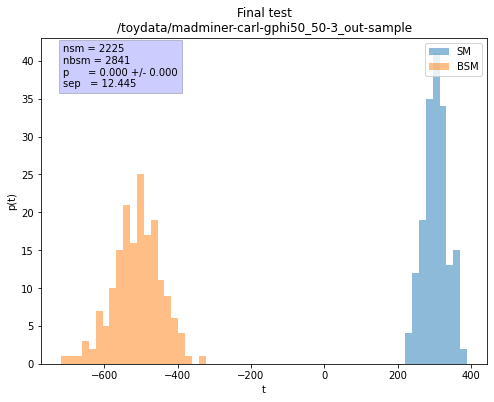

In [19]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl50-3')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_50-3_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 250.435,  tbsm = -240.987
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 13.99 sigmas
Partial test after 1 epochs (took 71.87 seconds)



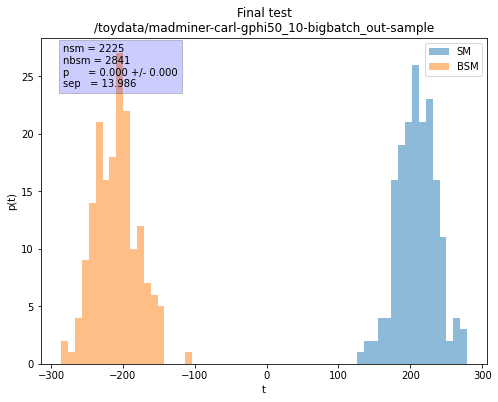

In [17]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl10-bigbatch')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_10-bigbatch_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 770.850,  tbsm = 164.990
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 13.61 sigmas
Partial test after 1 epochs (took 45.83 seconds)



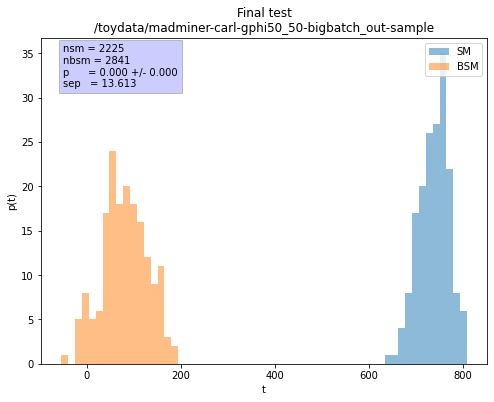

In [15]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl50-bigbatch')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_50-bigbatch_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 317.294,  tbsm = -419.716
Reaching the end of test data. Stop tests at 176. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 12.91 sigmas
Partial test after 1 epochs (took 37.76 seconds)



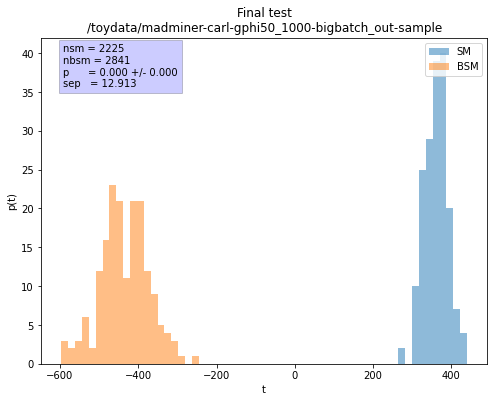

In [20]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl1000-bigbatch')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_1000-bigbatch_out-sample'%(gphival))

f.close()

# Out Sample Test Data
New 2D format

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 338.832,  tbsm = -431.554
Reaching the end of test data. Stop tests at 176. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 10.13 sigmas
Partial test after 1 epochs (took 29.76 seconds)



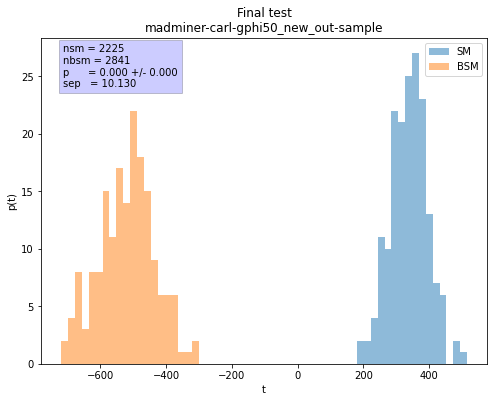

In [69]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2693.988
test 0   : tsm = 280.535,  tbsm = -460.285
Reaching the end of test data. Stop tests at 185. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 6.98 sigmas
Partial test after 1 epochs (took 70.00 seconds)



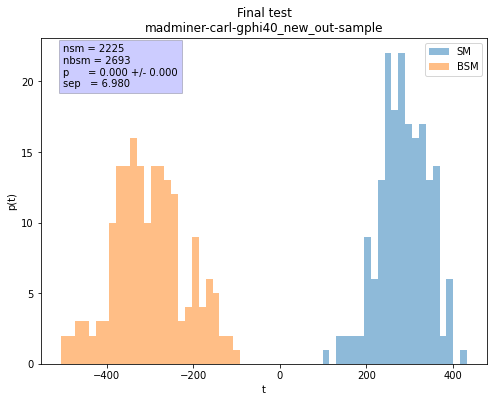

In [76]:
gphival = 40
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2558.585
test 0   : tsm = 230.843,  tbsm = -65.782
Reaching the end of test data. Stop tests at 195. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 5.32 sigmas
Partial test after 1 epochs (took 82.50 seconds)



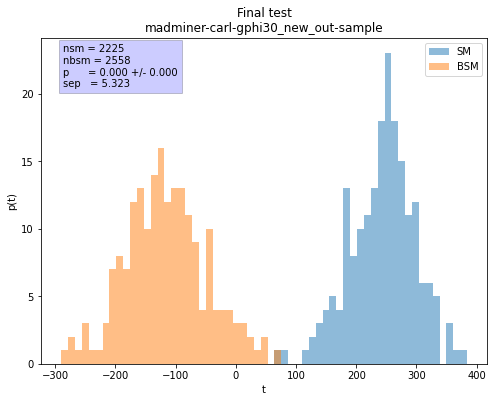

In [75]:
gphival = 30
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2436.280
test 0   : tsm = 253.924,  tbsm = -10.344
Reaching the end of test data. Stop tests at 205. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 3.07 sigmas
Partial test after 1 epochs (took 32.12 seconds)



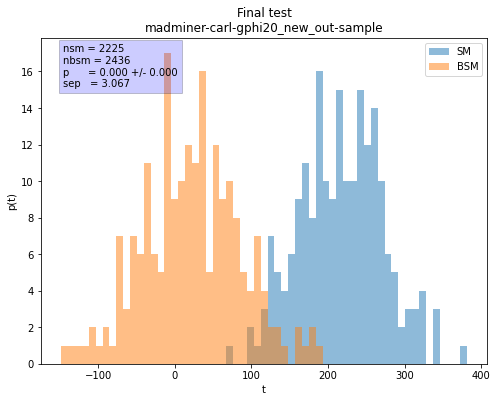

In [70]:
gphival = 20
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2325.162
test 0   : tsm = 259.370,  tbsm = 97.816
Reaching the end of test data. Stop tests at 215. 
===> delta1 = 0.021, delta2 = 0.014
p = 0.102 +/- 0.025
Separation = 1.20 sigmas
Partial test after 1 epochs (took 32.83 seconds)



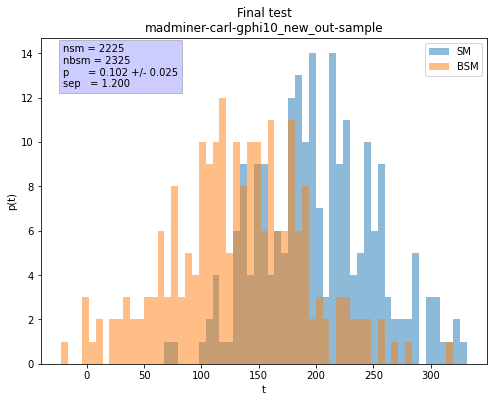

In [71]:
gphival = 10
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new_out-sample'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = 176.557,  tbsm = 129.605
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.029, delta2 = 0.031
p = 0.256 +/- 0.042
Separation = 0.53 sigmas
Partial test after 1 epochs (took 33.03 seconds)



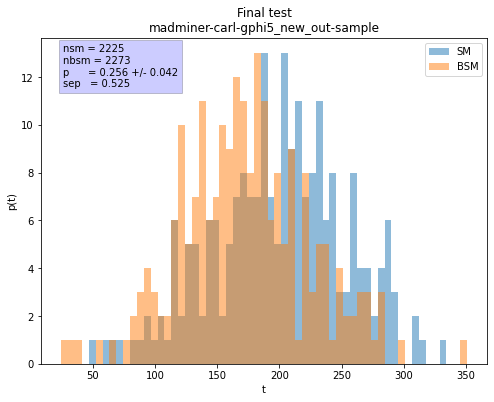

In [72]:
gphival = 5
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new_out-sample'%(gphival))

f.close()